In [39]:
import re
from collections import Counter, defaultdict
import itertools

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, TweetTokenizer
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package words to /Users/paolo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/paolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/paolo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paolo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/paolo/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


# Import data

In [4]:
df = pd.read_csv('./data/socialmedia-disaster-tweets-DFE.csv', encoding='iso-8859-1')

In [5]:
df.shape

(10876, 13)

In [6]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [9]:
df['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: choose_one, dtype: int64

#### Tokenization

In [8]:
df['word_list']  = df['text'].apply(lambda x: word_tokenize(x))

In [9]:
df['sentence_list']  = df['text'].apply(lambda x: sent_tokenize(x))

In [10]:
df['hashtags'] = df['text'].apply(lambda x: regexp_tokenize(x, r"@\w+|#\w+"))

In [11]:
df[['text','word_list', 'sentence_list','hashtags']].head(20)

,text,word_list,sentence_list,hashtags
0,Just happened a terrible car crash,"[Just, happened, a, terrible, car, crash]",[Just happened a terrible car crash],[]
1,Our Deeds are the Reason of this #earthquake M...,"[Our, Deeds, are, the, Reason, of, this, #, ea...",[Our Deeds are the Reason of this #earthquake ...,[#earthquake]
2,"Heard about #earthquake is different cities, s...","[Heard, about, #, earthquake, is, different, c...","[Heard about #earthquake is different cities, ...",[#earthquake]
3,"there is a forest fire at spot pond, geese are...","[there, is, a, forest, fire, at, spot, pond, ,...","[there is a forest fire at spot pond, geese ar...",[]
4,Forest fire near La Ronge Sask. Canada,"[Forest, fire, near, La, Ronge, Sask, ., Canada]","[Forest fire near La Ronge Sask., Canada]",[]
5,All residents asked to 'shelter in place' are ...,"[All, residents, asked, to, 'shelter, in, plac...",[All residents asked to 'shelter in place' are...,[]
6,"13,000 people receive #wildfires evacuation or...","[13,000, people, receive, #, wildfires, evacua...","[13,000 people receive #wildfires evacuation o...",[#wildfires]
7,Just got sent this photo from Ruby #Alaska as ...,"[Just, got, sent, this, photo, from, Ruby, #, ...",[Just got sent this photo from Ruby #Alaska as...,"[#Alaska, #wildfires]"
8,#RockyFire Update => California Hwy. 20 closed...,"[#, RockyFire, Update, =, >, California, Hwy, ...","[#RockyFire Update => California Hwy., 20 clos...","[#RockyFire, #CAfire, #wildfires]"
9,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting, ., #, Spokane, #, wildf...","[Apocalypse lighting., #Spokane #wildfires]","[#Spokane, #wildfires]"


In [12]:
tknz = TweetTokenizer()

In [13]:
all_tokens = [tknz.tokenize(t) for t in df['text'].values[:10]]

In [14]:
all_tokens

[['Just', 'happened', 'a', 'terrible', 'car', 'crash'],
 ['Our',
  'Deeds',
  'are',
  'the',
  'Reason',
  'of',
  'this',
  '#earthquake',
  'May',
  'ALLAH',
  'Forgive',
  'us',
  'all'],
 ['Heard',
  'about',
  '#earthquake',
  'is',
  'different',
  'cities',
  ',',
  'stay',
  'safe',
  'everyone',
  '.'],
 ['there',
  'is',
  'a',
  'forest',
  'fire',
  'at',
  'spot',
  'pond',
  ',',
  'geese',
  'are',
  'fleeing',
  'across',
  'the',
  'street',
  ',',
  'I',
  'cannot',
  'save',
  'them',
  'all'],
 ['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask', '.', 'Canada'],
 ['All',
  'residents',
  'asked',
  'to',
  "'",
  'shelter',
  'in',
  'place',
  "'",
  'are',
  'being',
  'notified',
  'by',
  'officers',
  '.',
  'No',
  'other',
  'evacuation',
  'or',
  'shelter',
  'in',
  'place',
  'orders',
  'are',
  'expected'],
 ['13,000',
  'people',
  'receive',
  '#wildfires',
  'evacuation',
  'orders',
  'in',
  'California'],
 ['Just',
  'got',
  'sent',
  'this',
  'ph

#### Words and word length

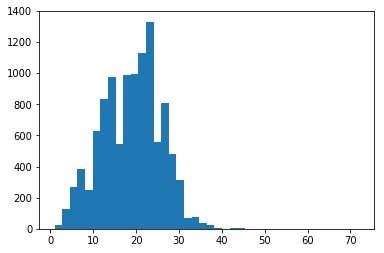

In [15]:
df['n_words'] = df['word_list'].apply(lambda x: len(x))
plt.hist(df['n_words'], bins=40)
plt.show()

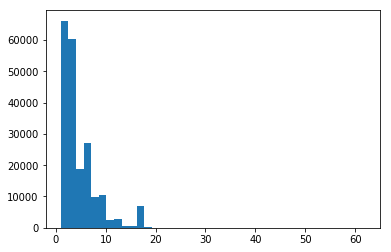

In [16]:
# Word lengths
word_lengths = [len(w) for t in df['word_list'].values for w in t]
plt.hist(word_lengths, bins=40)
plt.show()

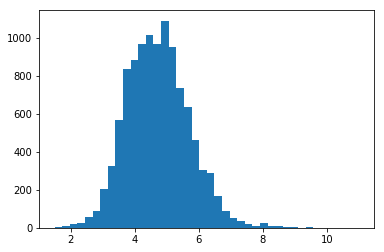

In [17]:
# Average word length
df['avg_word_len'] = df['word_list'].apply(lambda x: np.mean([len(w) for w in x]))
plt.hist(df['avg_word_len'], bins=40)
plt.show()

##### Text preprocessing

In [22]:
processed_tokens = all_word_tokens
# Keep only alphabetic tokens
# Note this will remove hashtags and mentions
processed_tokens = [word for word in processed_tokens if word.isalpha()]
# Remove stopwords
processed_tokens = [word for word in processed_tokens if word not in stopwords.words('english')]
# WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
processed_tokens = [lemmatizer.lemmatize(word) for word in processed_tokens]


In [23]:
processed_token_counter = Counter(processed_tokens)

In [24]:
processed_token_counter.most_common(15)

[('fire', 516),
 ('amp', 510),
 ('like', 495),
 ('get', 381),
 ('u', 355),
 ('new', 328),
 ('via', 325),
 ('one', 296),
 ('people', 283),
 ('year', 253),
 ('video', 234),
 ('time', 230),
 ('emergency', 227),
 ('would', 214),
 ('disaster', 214)]

# Naive Bayes

In [ ]:
y = df['choose_one']=='Relevant'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

In [13]:
count_vectorizer = CountVectorizer(stop_words='english')

In [16]:
# Note the difference between transform and fit_transforma
count_train = count_vectorizer.fit_transform(X_train.values)

In [18]:
count_test = count_vectorizer.transform(X_test.values)

In [25]:
count_vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '007npen6lg',
 '00cy9vxeff',
 '00end',
 '00pm',
 '01',
 '01hux8y9gi',
 '02']

In [26]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [27]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

In [28]:
tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [35]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df.head()

,00,000,0000,007npen6lg,00cy9vxeff,00end,00pm,01,01hux8y9gi,02,...,ûò,ûò7,ûò800000,ûòåêcnbc,ûó,ûóher,ûókill,ûónegligence,ûótech,ûówe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,00,000,0000,007npen6lg,00cy9vxeff,00end,00pm,01,01hux8y9gi,02,...,ûò,ûò7,ûò800000,ûòåêcnbc,ûó,ûóher,ûókill,ûónegligence,ûótech,ûówe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
count_df.equals(tfidf_df)

False

In [41]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
print(metrics.accuracy_score(pred, y_test))
metrics.confusion_matrix(y_test, pred, labels=[0,1])

0.801949860724234

In [57]:
class_labels = nb_classifier.classes_
feature_names = count_vectorizer.get_feature_names()

features_with_weights = sorted(zip(feature_names, nb_classifier.coef_[0]), key=lambda x: x[1], reverse=True)

In [58]:
features_with_weights[:10]

[('http', -5.197011421300342),
 ('news', -7.017874446951657),
 ('disaster', -7.043719321261869),
 ('û_', -7.071988862854877),
 ('hiroshima', -7.0784637795805505),
 ('suicide', -7.099441766583912),
 ('https', -7.104864563206208),
 ('california', -7.116086272663665),
 ('fires', -7.176443830692253),
 ('amp', -7.196376758935049)]

In [61]:
features_with_weights[-10:]

[('ûïparties', -10.32882125127746),
 ('ûïsippin', -10.32882125127746),
 ('ûïstretcher', -10.32882125127746),
 ('ûïtell', -10.32882125127746),
 ('ûïthis', -10.32882125127746),
 ('ûïwarning', -10.32882125127746),
 ('ûïwe', -10.32882125127746),
 ('ûò7', -10.32882125127746),
 ('ûòåêcnbc', -10.32882125127746),
 ('ûótech', -10.32882125127746)]

In [47]:
def train_and_predict(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(pred, y_test)
    return score

In [48]:
alphas = np.arange(0,1,.1)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


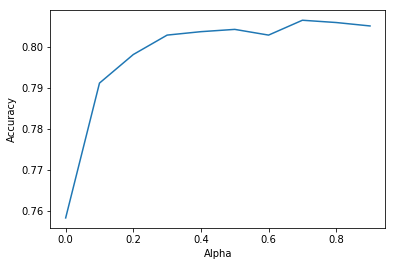

In [66]:
# Iterate over the alphas and print the corresponding score
plt.plot(alphas, [train_and_predict(alpha) for alpha in alphas])
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

In [44]:
metrics.confusion_matrix(y_test, pred, labels=[0,1])

array([[1886,  173],
       [ 527, 1004]])